Create Dataset from google play scraper and write it to csv files. It is created by following tutorials  of github.com/curiousily

In [ ]:
!pip install -qq google-play-scraper

     |████████████████████████████████| 51kB 2.5MB/s 


In [ ]:
!pip install -qq -U watermark


In [ ]:
%reload_ext watermark
%watermark -v -p pandas,matplotlib,seaborn,google_play_scraper

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

pandas             : 1.1.5
matplotlib         : 3.2.2
seaborn            : 0.11.1
google_play_scraper: 0.1.2



In [ ]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Which apps will be utilized

In [ ]:
packages = [
  'com.anydo',
  'com.todoist',
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner'
]

In [ ]:

app_infos = []

for package in tqdm(packages):
  info = app(package, lang='en', country='us')
  del info['comments']
  app_infos.append(info)

100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


In [ ]:

def print_json(json_object):
  json_str = json.dumps(
    json_object, 
    indent=2, 
    sort_keys=True, 
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

Just to make it look nicer, print can out json objects

In [ ]:
print_json(app_infos[-1])


{
  "adSupported": true,
  "androidVersion": "5.0",
  "androidVersionText": "5.0 and up",
  "appId": "com.appxy.planner",
  "containsAds": true,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "Designed for those people who\u2019re looking for a full-featured app to manage daily life better. Planner Pro, which costs years for designing and coding is now coming out for everybody especially those Franklin Covey Planner heavy users. We combine events, tasks and notes in one place so that you do not need to spend extra money for other apps, and it can be used as day planner, week planner and month planner.\r\n\r\nPlanner Pro provides kinds of settings for different requirements from kinds of people. You\u2019ll find the best way to meet your requirements in our app. Also, if you have any other great ideas or suggestions to make this app better please contact us with an email, which will be very appreciate. \r\n\r\nEvents\r\n- Sync wi

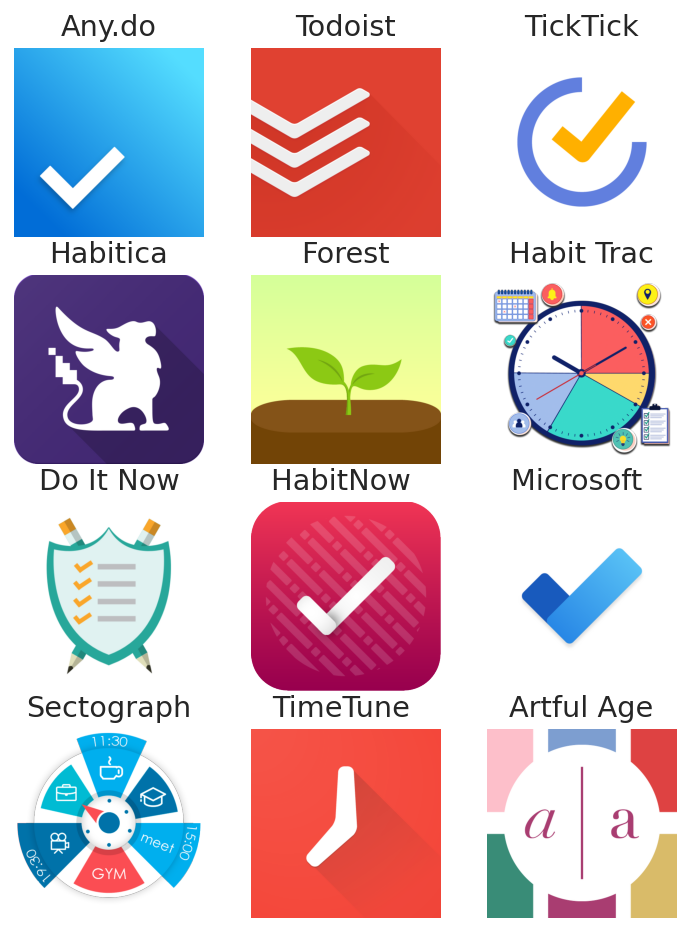

In [ ]:
def format_title(title):
  sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
  if sep_index != -1:
    title = title[:sep_index]
  return title[:10]

fig, axs = plt.subplots(4, len(app_infos) // 4, figsize=(6, 8))


#flat aces
for i, ax in enumerate(axs.flat):
  ai = app_infos[i]
  img = plt.imread(ai['icon'])
  ax.imshow(img)
  ax.set_title(format_title(ai['title']))
  ax.axis('off')

plt.show()

Ugly way of doing it. Using axes makes much more sense

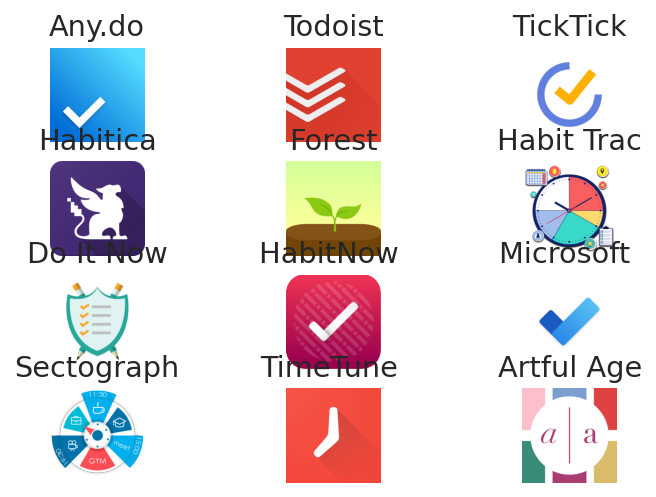

In [ ]:
for i in range(12):

  plt.subplot(4,3,i+1)
  ai = app_infos[i]
  img = plt.imread(ai['icon'])
  plt.imshow(img)
  plt.title(format_title(ai['title']))
  plt.axis('off')

plt.show()

# Get Comments in balanced way

In [ ]:
app_reviews = []

for package in tqdm(packages):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        package,
        lang='en',
        country='us',
        sort=sort_order,
        count= 200 if score == 3 else 100,
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = package
      app_reviews.extend(rvs)

100%|██████████| 15/15 [01:29<00:00,  5.96s/it]


In [ ]:
app_reviews[0]

{'appId': 'com.anydo',
 'at': datetime.datetime(2021, 2, 26, 4, 17, 49),
 'content': "Very very bad experience with the management! I have had no response at all what so ever from Any.do to my asking for help with my Apps for malfunction over the last 4 months for my Premium account which I have paid for. Even worse is there is no clear way to terminate of my payment for the Premium service of the Apps which I have expected for. That's why I am asking for help here hoping that the managment team would see this message and give me some help to solve the problem!",
 'repliedAt': None,
 'replyContent': None,
 'reviewCreatedVersion': '5.10.0.8',
 'reviewId': 'gp:AOqpTOHTeNGxl9Zhlz-BM6ybraEsnVg0BLDubF8E_fQTyUDJy1Le4U1ilQuS1b9ZtOfCR1Rf-VHiReqKDiYp5A',
 'score': 1,
 'sortOrder': 'most_relevant',
 'thumbsUpCount': 1,
 'userImage': 'https://play-lh.googleusercontent.com/-rSnBD4YnD5g/AAAAAAAAAAI/AAAAAAAAAAA/AMZuucn0DOMEPYwNYWMyHtlT5aaw5_ThBQ/photo.jpg',
 'userName': 'kelvin ho'}

Since we are taking from 2 sample most relevant and most popular same item may exists

In [ ]:
first_content = app_reviews[0]["content"]

for i,r in enumerate(app_reviews[1:]):
  
  if r["content"] == first_content:
    print("duplicate exists : ",i)
    break

duplicate exists :  100


In [ ]:
app_reviews_df = pd.DataFrame(app_reviews) #array of dictionary
app_reviews_df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOHTeNGxl9Zhlz-BM6ybraEsnVg0BLDubF8E_fQ...,kelvin ho,https://play-lh.googleusercontent.com/-rSnBD4Y...,Very very bad experience with the management! ...,1,1,5.10.0.8,2021-02-26 04:17:49,None,NaT,most_relevant,com.anydo
1,gp:AOqpTOH2VEhd1ldAR1zxGzjJEIa37fCBgY9S3sqe_TE...,Matt Van Der Schyff,https://play-lh.googleusercontent.com/-sMd4wLr...,originally gave this a 2 star but I think it o...,1,81,5.9.0.2,2021-02-04 05:35:28,We are unaware of any issues with setting remi...,2021-02-04 09:08:06,most_relevant,com.anydo
2,gp:AOqpTOH5OkwJH-nRT4nopD_JNTIYpWs1xWzOsFE-pn7...,Charles Green,https://play-lh.googleusercontent.com/a-/AOh14...,"Ugh! After years of using this app, I am so ve...",1,9,5.9.0.2,2021-02-17 19:10:03,"From checking our records, the issue you've re...",2021-02-18 11:22:00,most_relevant,com.anydo


In [ ]:
app_reviews_df.shape

(16430, 12)

In [ ]:
app_reviews_df.to_csv('reviews.csv', index=None, header=True)

Also write app infos to csv

In [ ]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('apps.csv', index=None, header=True)
